---
## Importing

In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import urllib.request
import json
from pandas import json_normalize

import folium

import time

In [2]:
pd.set_option('display.max_rows', 500)

# Defining Functions

### Mapping Functions

In [80]:
def plot_map(df, zoom=10):
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start = zoom)


    for lat, lng, label in zip(df['lat'], df['lng'], df.iloc[:, 0]):
    
        #label = folium.Popup(label, html_parser=True)
        folium.CircleMarker([lat, lng],
                            #popup=label,
                            radius=3,
                            color='darkred',
                            #fill=True,
                            #fill_color='blue',
                            #fill_oppacity=0.8
                           ).add_to(mapa)
    return mapa

In [5]:
def plot_map_lite(df, zoom=11):
    
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start=zoom)

    for lat, lng, label in zip(df['lat'].values, df['lng'].values, df.iloc[:, 0].values):
    
        #label = folium.Popup(label, html_parser=True)
        folium.CircleMarker([lat, lng],
                            #popup=label,
                            radius=2,
                            color='darkred',
                            #fill=True,
                            #fill_color='blue',
                            #fill_oppacity=0.8
                           ).add_to(mapa)
    return mapa

In [6]:
def plot_search_map(df, zoom=11):
    
     
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start=zoom)

    for lat, lng, label, radius in zip(df['lat'].values, df['lng'].values, df.iloc[:, 0].values, df['radius'].values):
    
        #label = folium.Popup(label, html_parser=True)
        folium.Circle([lat, lng],
                      #popup=label,
                      radius=radius,
                      color='darkred',
                      #fill=True,
                      #fill_color='blue',
                      #fill_oppacity=0.8
                     ).add_to(mapa)
    return mapa
    

### Foursquare Functions

#### Construct foursquare API url

In [7]:
def foursquare_url(query=False,
                   explore=False,
                   venue=False,
                   ctgr_search=False,
                   ctgr_explore=False,
                   search_query=None,
                   ctgr_id=None,
                   venue_id=None,
                   radius=1500,
                   LIMIT=800,
                   lat=-22.9719642,       # Rio de Janeiro Center Coords
                   lng=-43.1843432):

    CLIENT_ID = 'YBZLHWZRC4DJGEF2GVTRMDCQZBCZXDBC0ZXPAMHZFR0RF3BC' # your Foursquare ID
    CLIENT_SECRET = 'NXISZGNL4VVTR24LS2GE3ZVQ14URDHPP0S0UNJTC41CKFW4I' # your Foursquare Secret
    VERSION = '20200604'
    latitude=lat
    longitude=lng
    
    expl_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    query_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    venue_url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    ctgr_expl_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&category_Id={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT, ctgr_id)
    ctgr_srch_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT, ctgr_id)
    
    if ctgr_explore: return ctgr_expl_url
    if ctgr_search: return ctgr_srch_url
    if query: return query_url
    if explore: return expl_url
    if venue: return venue_url

#### Choose endpoint and search around locations

In [8]:
def get_venues(df,
               radius = 1000,
               explore=False,
               query=False,
               ctgr_search=False,
               ctgr_explore=False, 
               ctgr_id=None,
               search_query=None
              ):
    
    if type(radius)==int: radius = [radius for i in range(len(df))]

    keeper_cols = [df.columns[0], 'venue.id', 'venue.name', 'venue.category_id', 'venue.category', 'venue.location.lat', 'venue.location.lng', 'venue.location.distance']
    keeper_cols_ctgr = [df.columns[0], 'id', 'name', 'category_id', 'category', 'location.lat', 'location.lng', 'location.distance']
    rqst_fail = []
    append_fail = []
    cnt = 0
    
    if ctgr_search or query: hoods_expl = pd.DataFrame(columns=keeper_cols_ctgr)
    else: hoods_expl = pd.DataFrame(columns=keeper_cols)
    
    
    
    for name, lat, lng, radius in zip(df.iloc[:, 0], df['lat'], df['lng'], radius):
     
        try: rqst_txt = urllib.request.urlopen(foursquare_url(explore=explore,
                                                              query=query,
                                                              ctgr_search=ctgr_search,
                                                              ctgr_explore=ctgr_explore,
                                                              ctgr_id=ctgr_id,
                                                              search_query=search_query,
                                                              lat=lat, 
                                                              lng=lng,
                                                              radius=radius)).read().decode()[:]
        except: 
            try: rqst_txt = urllib.request.urlopen(foursquare_url(explore=True,     # Maybe this will only run whenexplore=True, in other words try above will fail if explore=True
                                                                  lat=lat, 
                                                                  lng=lng,
                                                                  radius=radius)).read().decode()[:]
            except:
                print(name)
                rqst_fail.append(name)
                continue

        
        if (not ctgr_search) and (not query): rqst_df = json_normalize(json.loads(rqst_txt)['response']['groups'][0]['items'])  
        
        else: 
            try: rqst_df = json_normalize(json.loads(rqst_txt)['response']['venues'])
            except: 
                append_fail.append(name)
                continue
        
        if len(rqst_df)==0: 
            append_fail.append(name)
            continue
        
        rqst_df[keeper_cols[0]] = [name for i in range(len(rqst_df))]
    
        if (not ctgr_search) and (not query):            
            if 'venue.categories' in rqst_df.columns:
                rqst_df['venue.category_id'] = [i[0]['id'] if i!=[] else np.nan for i in rqst_df['venue.categories']] 
                rqst_df['venue.category'] = [i[0]['name'] if i!=[] else np.nan for i in rqst_df['venue.categories']]   
            else: 
                rqst_df['venue.category_id'] = [np.nan for i in range(len(rqst_df))]
                rqst_df['venue.category'] = [np.nan for i in range(len(rqst_df))]
                
            hoods_expl = pd.concat([hoods_expl, rqst_df[keeper_cols]], axis=0)
            
        else:
            if 'categories' in rqst_df.columns:
                rqst_df['category_id'] = [i[0]['id'] if i!=[] else np.nan for i in rqst_df['categories']] 
                rqst_df['category'] = [i[0]['name'] if i!=[] else np.nan for i in rqst_df['categories']]   
            else: 
                rqst_df['category_id'] = [np.nan for i in range(len(rqst_df))]
                rqst_df['category'] = [np.nan for i in range(len(rqst_df))]
                
            hoods_expl = pd.concat([hoods_expl, rqst_df[keeper_cols_ctgr]], axis=0)
        
        
        cnt+=1
        if cnt in range(0, len(df), 10): print('appended:', cnt, 'rqst_fail:', len(rqst_fail), 'append_fail:', len(append_fail))
    
    print('Searched:', len(df), 'Failed:', len(append_fail)+len(rqst_fail))
    print('Fail list: ', append_fail)
    print('Completed')
    return hoods_expl.reset_index(drop=True)


# Loading Neighborhoods Data

In [16]:
hoods = pd.read_csv('/Users/luisr/Desktop/Repository/IBM_courses/Course Work/Assignments/Final Capstone Project/rio dataframes/Outside Data/Clean/complete_bairros_fixed.csv')

# Searching for Gyms Inside Neighborhoods Radiuses

In [20]:
gyms = get_venues(hoods, radius=hoods['radius'], ctgr_search=True, ctgr_id='4bf58dd8d48988d176941735')

appended: 10 rqst_fail: 0 append_fail: 5
appended: 20 rqst_fail: 0 append_fail: 6
appended: 30 rqst_fail: 0 append_fail: 7
appended: 40 rqst_fail: 0 append_fail: 9
appended: 50 rqst_fail: 0 append_fail: 10
appended: 60 rqst_fail: 0 append_fail: 11
appended: 70 rqst_fail: 0 append_fail: 13
appended: 80 rqst_fail: 0 append_fail: 14
appended: 90 rqst_fail: 0 append_fail: 16
appended: 100 rqst_fail: 0 append_fail: 16
appended: 110 rqst_fail: 0 append_fail: 17
appended: 120 rqst_fail: 0 append_fail: 18
appended: 130 rqst_fail: 0 append_fail: 19
appended: 140 rqst_fail: 0 append_fail: 20
Searched: 163 Failed: 21
Fail list:  ['acari', 'água santa', 'bancários', 'barra de guaratiba', 'barros filho', 'caju', 'cidade nova', 'costa barros', 'engenheiro leal', 'gericinó', 'grumari', 'jacarezinho', 'joá', 'mangueira', 'moneró', 'paquetá', 'praia da bandeira', 'são francisco xavier', 'turiaçu', 'vasco da gama', 'zumbi']
Completed


In [22]:
fail = ['acari', 'água santa', 'bancários', 'barra de guaratiba', 'barros filho', 'caju', 'cidade nova', 'costa barros', 'engenheiro leal', 'gericinó', 'grumari', 'jacarezinho', 'joá', 'mangueira', 'moneró', 'paquetá', 'praia da bandeira', 'são francisco xavier', 'turiaçu', 'vasco da gama', 'zumbi']

In [ ]:
plot_map_lite(hoods[hoods['bairros'].isin(fail)])

# Cleaning

In [82]:
gyms.rename(columns={'location.lat':'lat', 'location.lng':'lng'}, inplace=True)

#  Saving/Loading Gyms Sample

In [102]:
#gyms.to_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\gym_search.csv', index=False)

In [3]:
gyms = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\gym_search.csv')

#  Exploratory Data Analysis

In [84]:
plot_map_lite(gyms)

In [55]:
gyms.drop_duplicates(subset=['bairros', 'name', 'lat']).shape, gyms.shape

((1209, 8), (1209, 8))

In [54]:
gyms.drop_duplicates(subset=['name','lat']).shape

(972, 8)

#### We have 972 unique gyms, so 237 gyms are considered to belong to more than one neighborhood in this study.

In [71]:
count = gyms.groupby('bairros').count()['id']

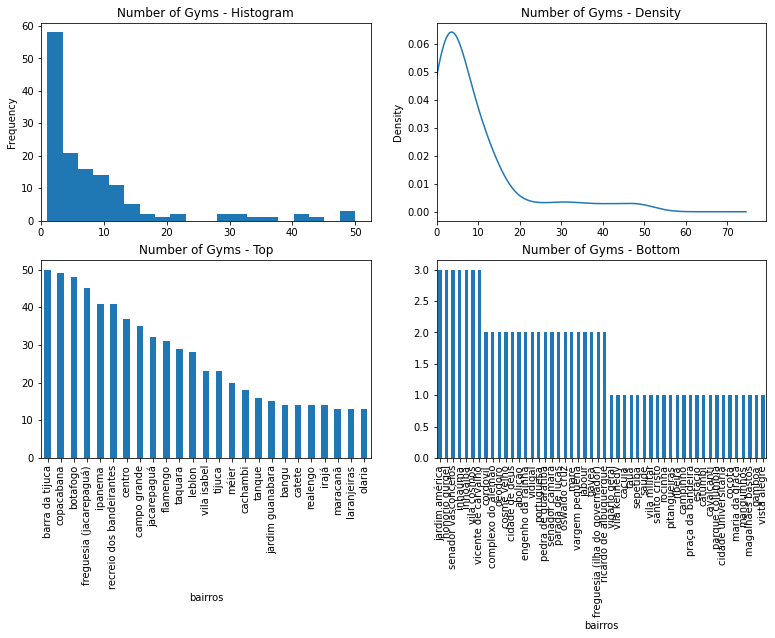

In [100]:
fig = plt.figure(figsize=(13, 8))
ax0 = fig.add_subplot(2,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)

count.sort_values(ascending=False).head(25).plot.bar(ax=ax2, title='Number of Gyms - Top')
count.sort_values(ascending=False).tail(50).plot.bar(ax=ax3, title='Number of Gyms - Bottom')
count.plot.hist(xlim=(0), ax=ax0, bins=20, title='Number of Gyms - Histogram')
count.plot.kde(xlim=(0), ax=ax1, title='Number of Gyms - Density')

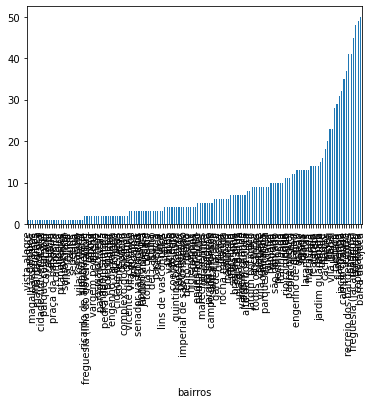

In [99]:
count.sort_values().plot.bar(xticks=None)